<a href="https://colab.research.google.com/github/svetlanama/experimental_design_and_data_reproducibility/blob/main/_Svitlana_Surname_Practical2_identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# @title Install + Imports
!pip -q install biopython

import io, re, math, gzip, pathlib, statistics
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO

# Colab upload helper
try:
    from google.colab import files
    IN_COLAB = True
except:
    IN_COLAB = False

print("Ready. IN_COLAB =", IN_COLAB)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.1 MB/s eta 0:00:00
Ready. IN_COLAB = True


In [5]:
# @title Upload your FASTA files (e.g., DS1.fasta, DS2.fasta, DS3.fasta)
if IN_COLAB:
    uploaded = files.upload()  # choose your files from seq_reads/
    fasta_paths = [pathlib.Path(name) for name in uploaded.keys()]
else:
    # If running locally, set your paths here:
    fasta_paths = [pathlib.Path("seq_reads/DS1.fasta"),
                   pathlib.Path("seq_reads/DS2.fasta"),
                   pathlib.Path("seq_reads/DS3.fasta")]
fasta_paths


Saving DS1.fasta to DS1.fasta
Saving DS2.fasta to DS2.fasta


[PosixPath('DS1.fasta'), PosixPath('DS2.fasta')]

In [6]:
# @title Helpers: parsing, per-read metrics, summaries

def open_maybe_gzip(path: pathlib.Path):
    """Return a file handle for plain or .gz FASTA."""
    if str(path).endswith(".gz"):
        return io.TextIOWrapper(gzip.open(path, "rb"))
    return open(path, "r")

def shannon_entropy(seq: str) -> float:
    """Shannon entropy (bits) over A/C/G/T/N frequencies."""
    seq = seq.upper()
    counts = Counter(seq)
    total = sum(counts.get(base, 0) for base in "ACGTN")
    if total == 0:
        return 0.0
    ent = 0.0
    for base in "ACGTN":
        p = counts.get(base, 0) / total
        if p > 0:
            ent -= p * math.log2(p)
    return round(ent, 4)

def longest_homopolymer(seq: str) -> int:
    """Length of the longest run of the same base."""
    if not seq:
        return 0
    max_run, run = 1, 1
    for i in range(1, len(seq)):
        if seq[i] == seq[i-1]:
            run += 1
            max_run = max(max_run, run)
        else:
            run = 1
    return max_run

def per_read_metrics(record):
    s = str(record.seq).upper().replace("U","T")
    length = len(s)
    counts = Counter(s)
    gc = (counts.get("G",0) + counts.get("C",0)) / length * 100 if length else 0.0
    n_count = counts.get("N", 0)
    ent = shannon_entropy(s)
    lhp = longest_homopolymer(s)
    return {
        "id": record.id,
        "length": length,
        "gc_percent": round(gc, 4),
        "n_count": n_count,
        "entropy_bits": ent,
        "longest_homopolymer": lhp,
        "sequence": s
    }

def analyze_fasta(path: pathlib.Path) -> pd.DataFrame:
    rows = []
    with open_maybe_gzip(path) as handle:
        for rec in SeqIO.parse(handle, "fasta"):
            rows.append(per_read_metrics(rec))
    df = pd.DataFrame(rows)
    df["file"] = path.name
    return df

def summarize_df(df: pd.DataFrame) -> pd.DataFrame:
    """One summary row per file."""
    out = []
    for fname, g in df.groupby("file"):
        lengths = g["length"].tolist()
        gc = g["gc_percent"].tolist()
        ns = g["n_count"].sum()
        dup_pct = (1 - g["sequence"].nunique() / len(g)) * 100 if len(g) else 0
        out.append({
            "file": fname,
            "reads": len(g),
            "avg_length": round(float(np.mean(lengths)), 2) if lengths else 0,
            "min_length": int(np.min(lengths)) if lengths else 0,
            "max_length": int(np.max(lengths)) if lengths else 0,
            "median_length": int(np.median(lengths)) if lengths else 0,
            "GC% (mean)": round(float(np.mean(gc)), 2) if gc else 0.0,
            "GC% (stdev)": round(float(np.std(gc, ddof=1)), 2) if len(gc) > 1 else 0.0,
            "total_Ns": int(ns),
            "reads_with_N": int((g["n_count"] > 0).sum()),
            "dup_reads_%": round(dup_pct, 2),
            "avg_entropy_bits": round(float(np.mean(g["entropy_bits"])), 3),
            "avg_longest_homopolymer": round(float(np.mean(g["longest_homopolymer"])), 2),
        })
    return pd.DataFrame(out).sort_values("file").reset_index(drop=True)


In [4]:
print(">>>>> fasta_paths:", fasta_paths)

>>>>> fasta_paths: [PosixPath('DS1.fasta'), PosixPath('DS2.fasta')]


In [7]:
# @title Parse all uploaded FASTAs
all_reads = []
for p in fasta_paths:
    dfp = analyze_fasta(p)
    all_reads.append(dfp)

reads_df = pd.concat(all_reads, ignore_index=True) if all_reads else pd.DataFrame()
print("Parsed reads:", len(reads_df))
reads_df.head(3)


Parsed reads: 20000


,id,length,gc_percent,n_count,entropy_bits,longest_homopolymer,sequence,file
0,DS1_read_00001,529,49.7164,3,2.0364,4,GCCCAATAAACCACTCTGACTGGCCGAATAGGGATATAGGCAACGA...,DS1.fasta
1,DS1_read_00002,214,46.7290,1,2.0222,5,GGTGTTAACTTCTGTTTAGTGGGCTAAAATAGCAGATGTAGGGACC...,DS1.fasta
2,DS1_read_00003,378,53.9683,2,2.0273,4,AGTGAATGCACTACACGGTACTGGTACGTGGCAACTTAGGTCGTCA...,DS1.fasta


In [8]:
# @title Summary table per file
summary = summarize_df(reads_df)
summary


,file,reads,avg_length,min_length,max_length,median_length,GC% (mean),GC% (stdev),total_Ns,reads_with_N,dup_reads_%,avg_entropy_bits,avg_longest_homopolymer
0,DS1.fasta,10000,399.11,150,650,399,49.74,2.70,20454,7304,0.0,2.026,4.94
1,DS2.fasta,10000,398.84,150,650,400,49.78,2.72,19982,7179,0.0,2.026,4.95


### **CHALLENGE 1:**

**CHALLENGE 1.1:**

Visualize and analyze data quality:

1. Plot DNA length v. Q, length v. number of N ambiguities, Q v. N

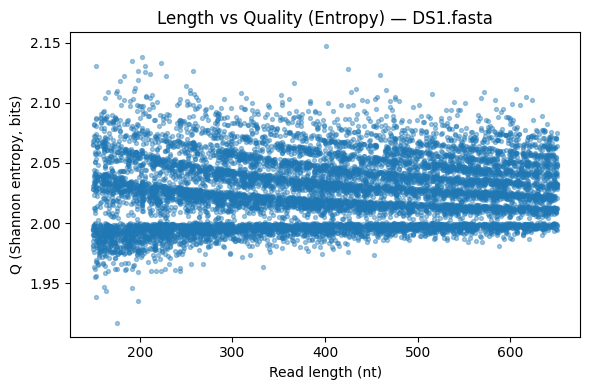

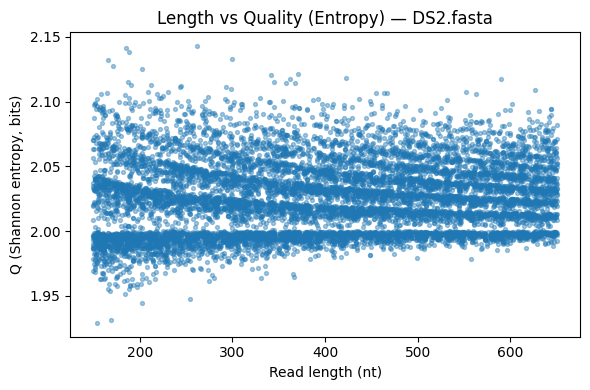

In [8]:
# Plot 1: DNA length vs Q (entropy)
import matplotlib.pyplot as plt

if "entropy_bits" not in reads_df.columns:
    raise ValueError("Missing 'entropy_bits' column. Run the earlier analysis cell first.")

for fname, g in reads_df.groupby("file"):
    plt.figure(figsize=(6,4))
    plt.scatter(g["length"], g["entropy_bits"], s=8, alpha=0.4)
    plt.title(f"Length vs Quality (Entropy) — {fname}")
    plt.xlabel("Read length (nt)")
    plt.ylabel("Q (Shannon entropy, bits)")
    plt.tight_layout()
    plt.show()


Main points:
- Entropy values a bit clustered around ~2.0 bits for both DS1 and DS2
- Entropy does not increase a lot with read length (it’s flat across 150–650 nt).

It means, that sequence complexity is stable, however, this is expected in synthetic datasets.



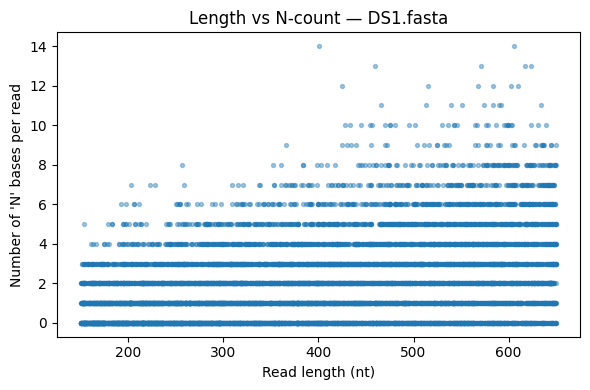

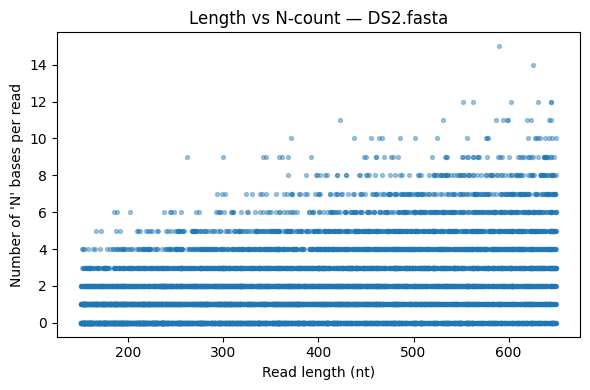

In [9]:
# Plot 2: DNA length vs number of N ambiguities
for fname, g in reads_df.groupby("file"):
    plt.figure(figsize=(6,4))
    plt.scatter(g["length"], g["n_count"], s=8, alpha=0.4)
    plt.title(f"Length vs N-count — {fname}")
    plt.xlabel("Read length (nt)")
    plt.ylabel("Number of 'N' bases per read")
    plt.tight_layout()
    plt.show()


It seems that both DS1 and DS2 behave similarly:

- For shorter reads, there is almost no ambiguity (most have 0 N bases).
- For longer reads > 400 nucleotides (nt), the number of N bases can rise, in some cases reaching up to 10–14.
This pattern proves that the data was artificially (synthetically) generated, with controlled noise.

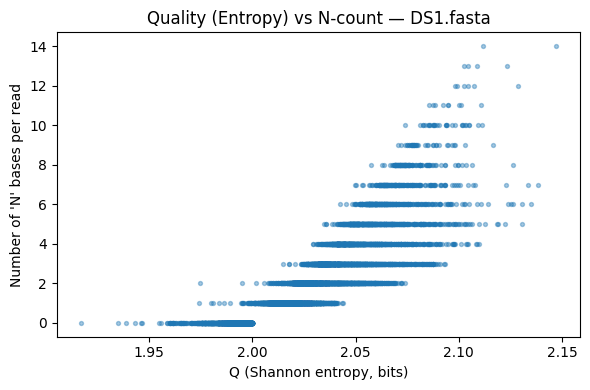

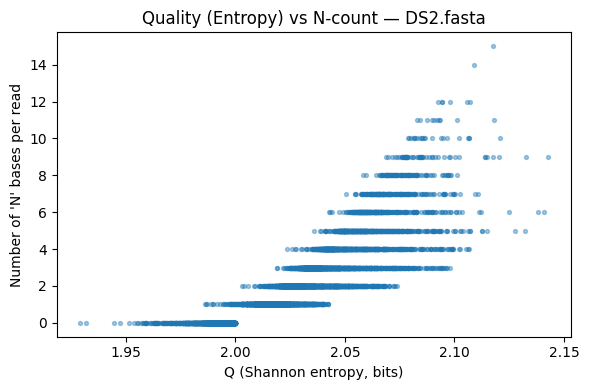

In [10]:
# Plot 3: Q (entropy) vs N ambiguities
for fname, g in reads_df.groupby("file"):
    plt.figure(figsize=(6,4))
    plt.scatter(g["entropy_bits"], g["n_count"], s=8, alpha=0.4)
    plt.title(f"Quality (Entropy) vs N-count — {fname}")
    plt.xlabel("Q (Shannon entropy, bits)")
    plt.ylabel("Number of 'N' bases per read")
    plt.tight_layout()
    plt.show()


**Plot3:**
Both DS1 and DS2 show a positive correlation between the number of N bases and entropy:
- Reads with 0–2 Ns cluster around entropy ~2.0 (high quality).
- As the number of Ns increases, entropy gradually shifts upward to ~2.1.

Pattern looks quite linear

# **Conslusion **


We looked at three things:
- Sequence length – how many letters are in the DNA string.
- Quality/complexity (entropy) – how diverse the letters (A, T, G, C) are. If all are the same → low quality; if they are different → high quality.
- Number of “N” – these are letters that appear when the machine doesn’t know which base should be there (uncertainty).

All 3 plots shows good quality of data, small entropy distribution, small values of uncertainty.  This pattern proves that the data was artificially (synthetically) generated, with controlled noise.




**CHALLENGE 1.2:**


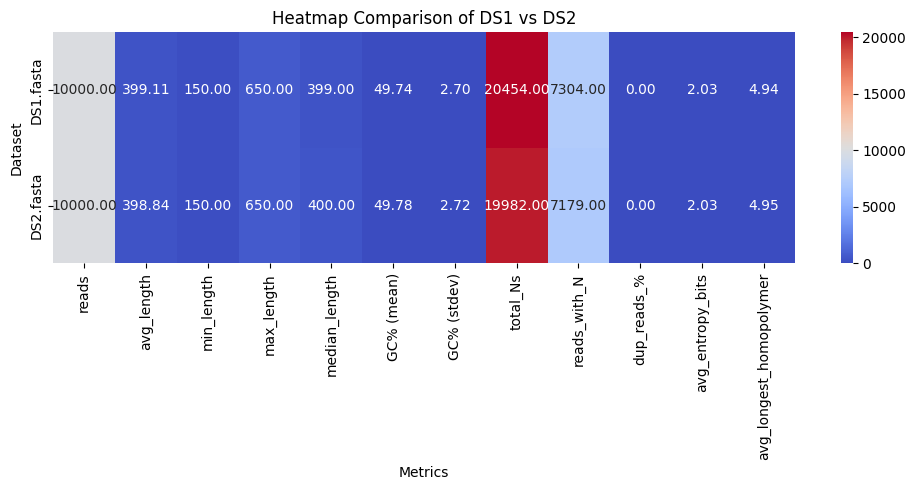

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


# Pick only numeric columns for heatmap
numeric_summary = summary.set_index("file").select_dtypes(include=[float, int])

plt.figure(figsize=(10,5))
sns.heatmap(numeric_summary, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Comparison of DS1 vs DS2")
plt.ylabel("Dataset")
plt.xlabel("Metrics")
plt.tight_layout()
plt.show()


- Reads (10,000 each) → Both DS1 and DS2 have the same number of reads.
- Lengths (~150–650, average ~399) → Very similar read lengths.
- GC% (~50%) → Both datasets have ~50% G + C content, nicely balanced.
- Ns (uncertain bases) →
- - DS1 has 20,454 total N
- - DS2 has 19,982 total N,
 almost the same, but DS1 slightly more.
- Reads with N (~7,200 each) → Around 70% of reads in both sets have at least one N.
- Entropy (~2.03 bits) → Both datasets have the same complexity.
- Longest homopolymer (~5 bases)

# **Conslusion **

DS1 and DS2 are almost identical: both have ~10k reads, average length ~399 nt, and balanced GC%. The only small difference is that DS1 has a bit more ambiguous bases (N) than DS2, but overall both datasets are synthetic and very similar in quality.

### **CHALLENGE 2:**

# ADDITIONAL

=================

Data Visualization (for me mostly, to understand what elsewe can see)  

=================






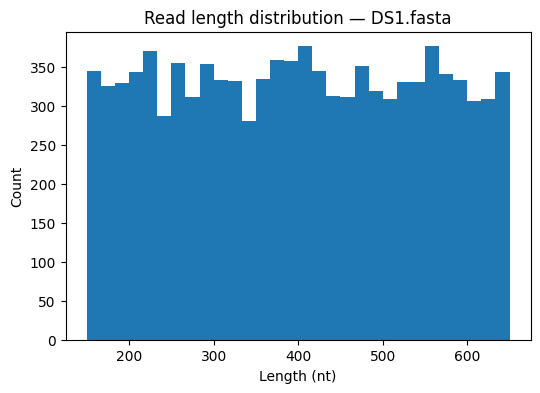

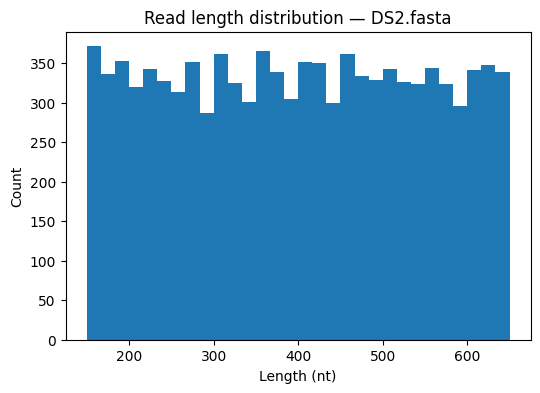

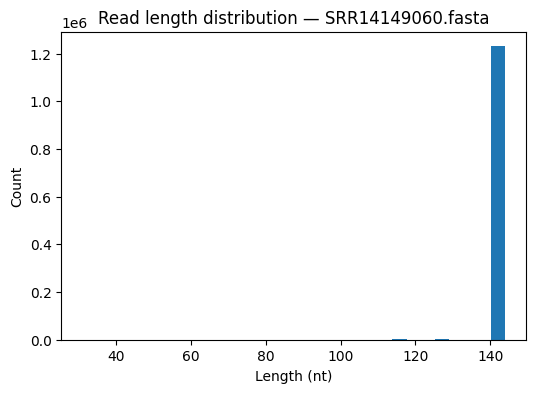

In [ ]:
# @title Histograms of read length (per file)
for fname, g in reads_df.groupby("file"):
    plt.figure(figsize=(6,4))
    plt.hist(g["length"], bins=30)
    plt.title(f"Read length distribution — {fname}")
    plt.xlabel("Length (nt)")
    plt.ylabel("Count")
    plt.show()


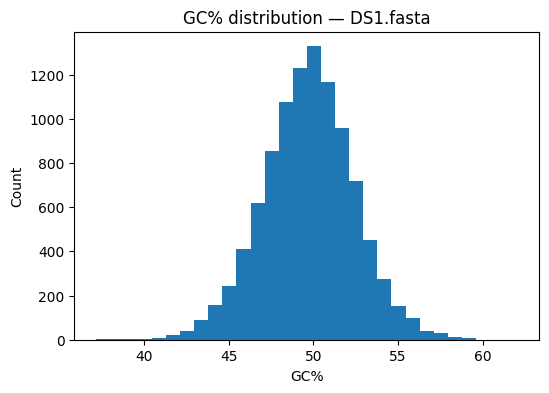

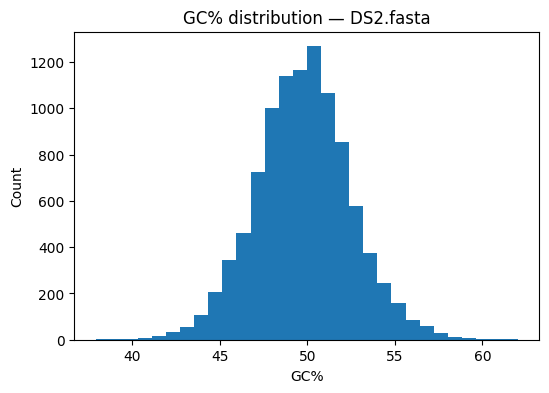

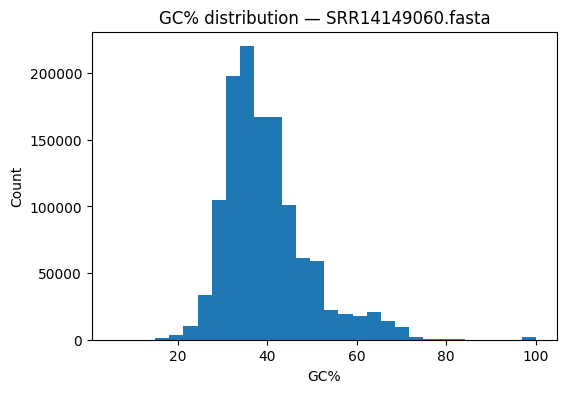

In [ ]:
# @title GC% distribution (per file)
for fname, g in reads_df.groupby("file"):
    plt.figure(figsize=(6,4))
    plt.hist(g["gc_percent"], bins=30)
    plt.title(f"GC% distribution — {fname}")
    plt.xlabel("GC%")
    plt.ylabel("Count")
    plt.show()


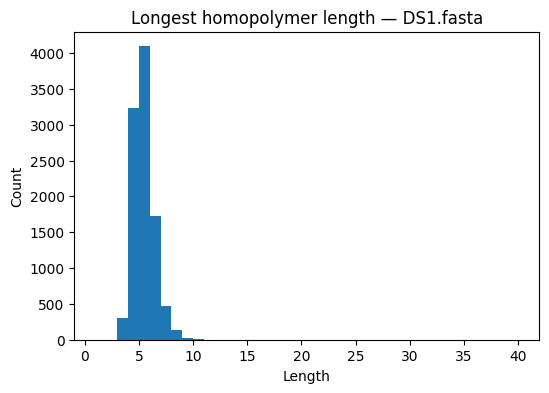

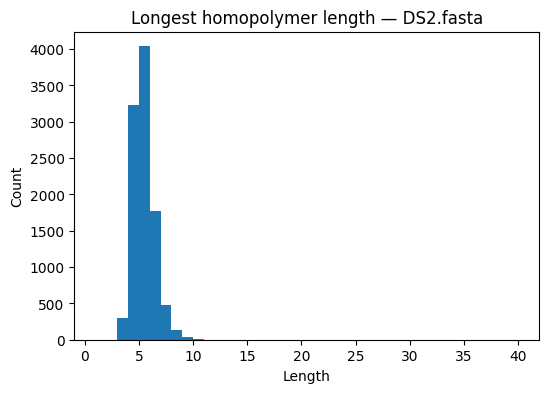

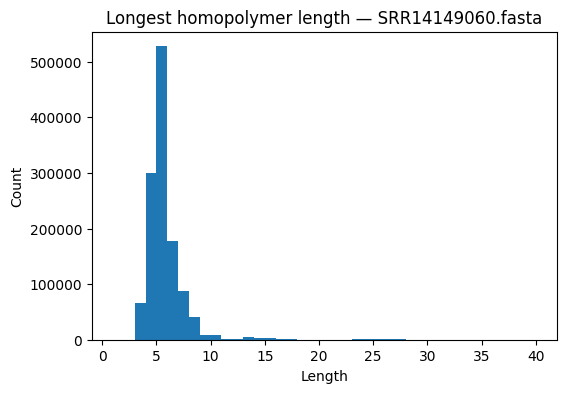

In [ ]:
# @title Longest homopolymer distribution (per file)
for fname, g in reads_df.groupby("file"):
    plt.figure(figsize=(6,4))
    plt.hist(g["longest_homopolymer"], bins=range(1, 41))
    plt.title(f"Longest homopolymer length — {fname}")
    plt.xlabel("Length")
    plt.ylabel("Count")
    plt.show()


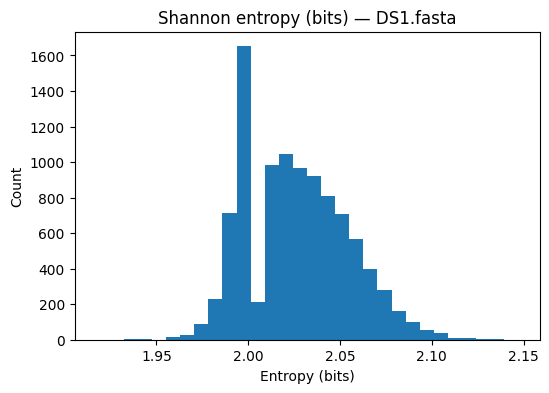

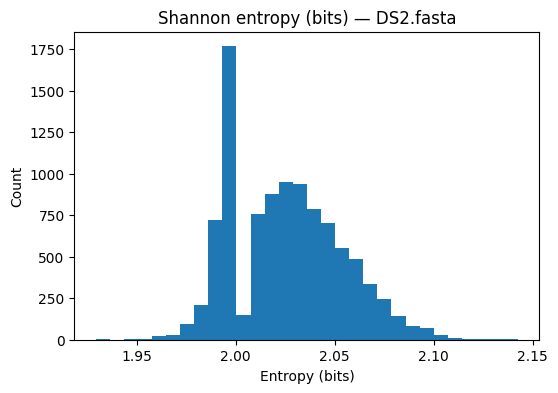

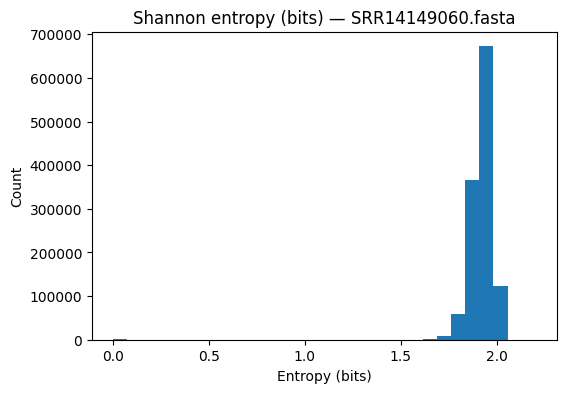

In [ ]:
# @title Entropy distribution (per file)
for fname, g in reads_df.groupby("file"):
    plt.figure(figsize=(6,4))
    plt.hist(g["entropy_bits"], bins=30)
    plt.title(f"Shannon entropy (bits) — {fname}")
    plt.xlabel("Entropy (bits)")
    plt.ylabel("Count")
    plt.show()


In [ ]:
# @title Simple quality flags (tweak thresholds as needed)

def quality_flags(g: pd.DataFrame):
    flags = []
    # % reads with N
    pct_reads_with_N = 100 * (g["n_count"] > 0).mean()
    if pct_reads_with_N > 5:
        flags.append(f"High ambiguous bases: {pct_reads_with_N:.1f}% reads contain 'N' (>5%)")
    # long homopolymer
    pct_long_hpoly = 100 * (g["longest_homopolymer"] >= 8).mean()
    if pct_long_hpoly > 5:
        flags.append(f"Long homopolymers: {pct_long_hpoly:.1f}% reads have runs ≥8")
    # extreme GC
    gc = g["gc_percent"]
    if (gc.mean() < 30) or (gc.mean() > 70):
        flags.append(f"GC bias: mean GC={gc.mean():.1f}% (outside 30–70%)")
    # duplicates
    dup_pct = (1 - g["sequence"].nunique() / len(g)) * 100 if len(g) else 0
    if dup_pct > 10:
        flags.append(f"High duplication: {dup_pct:.1f}% duplicate reads (>10%)")
    # low entropy
    low_ent_pct = 100 * (g["entropy_bits"] < 1.5).mean()
    if low_ent_pct > 10:
        flags.append(f"Low-complexity: {low_ent_pct:.1f}% reads entropy < 1.5 bits")
    return flags

issue_report = {}
for fname, g in reads_df.groupby("file"):
    issue_report[fname] = quality_flags(g)

for k, v in issue_report.items():
    print(f"\n=== {k} ===")
    if v:
        for f in v:
            print(" -", f)
    else:
        print(" No major issues flagged by simple heuristics.")



=== DS1.fasta ===
 - High ambiguous bases: 73.0% reads contain 'N' (>5%)

=== DS2.fasta ===
 - High ambiguous bases: 71.8% reads contain 'N' (>5%)

=== SRR14149060.fasta ===
 - Long homopolymers: 6.4% reads have runs ≥8
 - High duplication: 87.6% duplicate reads (>10%)


In [ ]:
# @title Side-by-side comparison: DS1 vs DS2 (auto-detect by name)
def pick(name_like):
    # choose first file that contains the token (case-insensitive)
    for f in reads_df["file"].unique():
        if name_like.lower() in f.lower():
            return f
    return None

file1 = pick("DS1") or pick("ds1")
file2 = pick("DS2") or pick("ds2")

if file1 and file2:
    s = summary.set_index("file").loc[[file1, file2]]
    display(s)
else:
    print("Could not auto-detect DS1 or DS2 filenames. Use your actual names.")


,reads,avg_length,min_length,max_length,median_length,GC% (mean),GC% (stdev),total_Ns,reads_with_N,dup_reads_%,avg_entropy_bits,avg_longest_homopolymer
file,,,,,,,,,,,,
DS1.fasta,10000,399.11,150,650,399,49.74,2.70,20454,7304,0.0,2.026,4.94
DS2.fasta,10000,398.84,150,650,400,49.78,2.72,19982,7179,0.0,2.026,4.95


In [ ]:
# @title Save per-read metrics and summary to CSV (downloads in Colab)
reads_csv = "reads_metrics_all.csv"
summary_csv = "summary_per_file.csv"
reads_df.to_csv(reads_csv, index=False)
summary.to_csv(summary_csv, index=False)
if IN_COLAB:
    files.download(reads_csv)
    files.download(summary_csv)
print("Saved:", reads_csv, "and", summary_csv)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved: reads_metrics_all.csv and summary_per_file.csv
